In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt

In [27]:
df = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv', index_col=0)
df['t'] = pd.to_datetime({'year': df.index.values + 1780,
                          'month': 1,
                          'day': 1})
df.head()

,x,t
1,272.3,1782-01-01
2,207.8,1783-01-01
3,545.7,1784-01-01
4,557.5,1785-01-01
5,260.6,1786-01-01


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 1 to 208
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   x       208 non-null    float64       
 1   t       207 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


***

### Скользящее среднее

In [12]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window_size=30, figsize=(20, 7)):
    rolling_mean = ts.rolling(window=window_size).mean()
    rolling_std = ts.rolling(window=window_size).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window_size:], label="Реальные значения", color='black')
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window_size), color='red')
    if plot_intervals:
        lower_bound = rolling_mean - 1.96*rolling_std
        upper_bound = rolling_mean + 1.96*rolling_std
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.show()

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\773236437.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window_size), color='red')


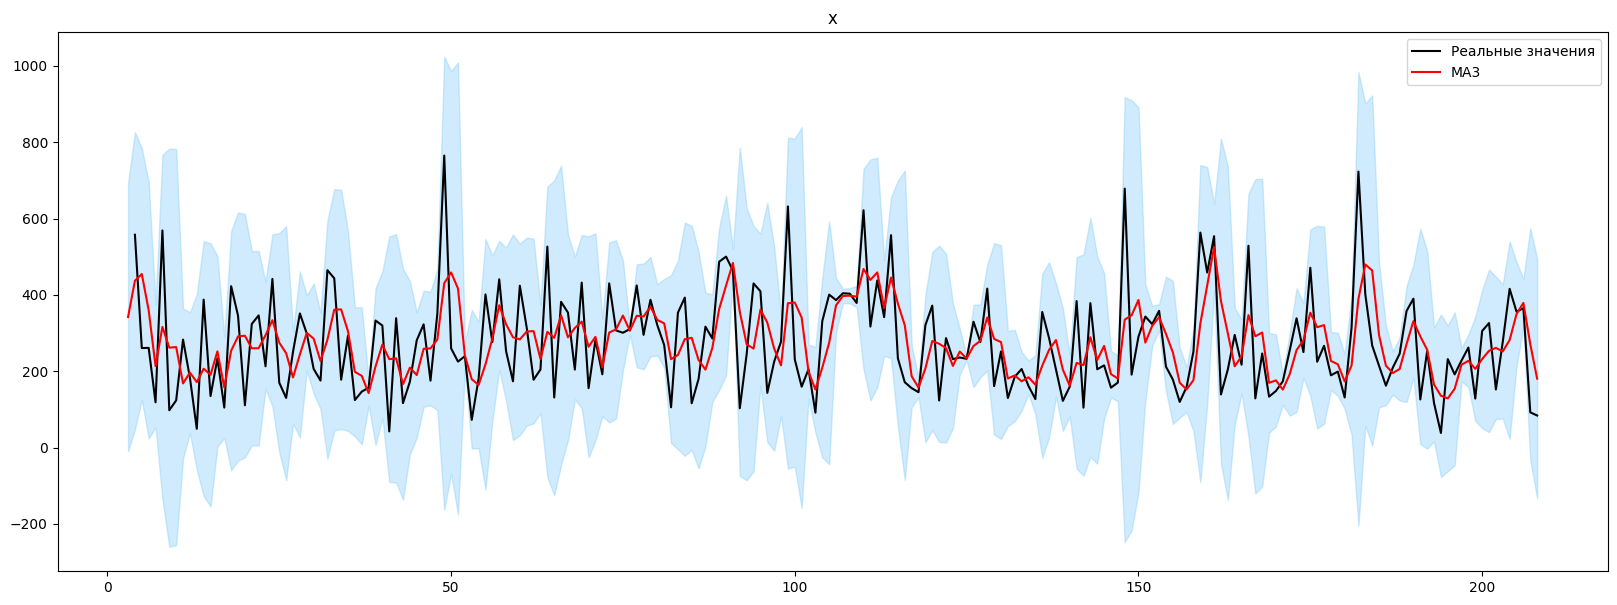

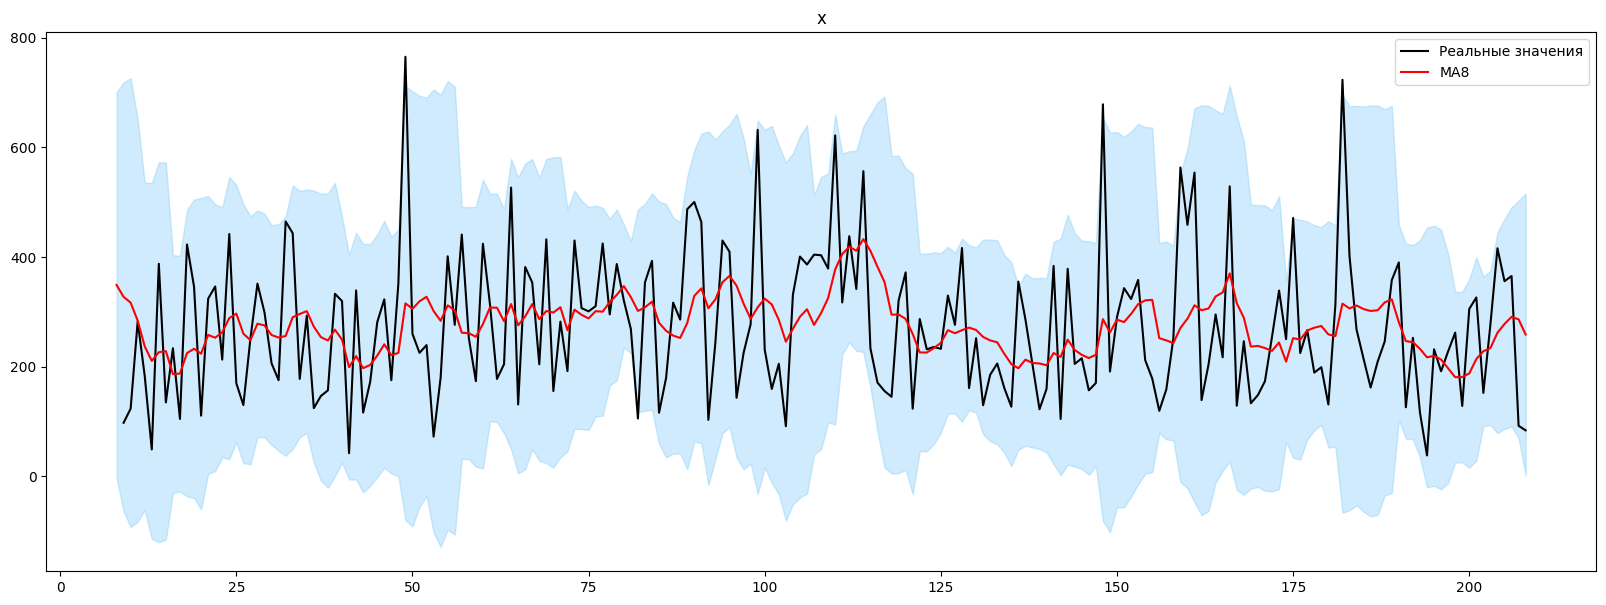

In [18]:
plot_ts(df.x, window_size=3)
plot_ts(df.x, window_size=8)

***

### Модель ARIMA

In [81]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [39]:
arma_model = ARIMA(df.x, order=(50, 0, 3))

arma_model_fit = arma_model.fit()

print(arma_model_fit.summary())

c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  208
Model:                ARIMA(50, 0, 3)   Log Likelihood               -1276.631
Date:                Sun, 10 Mar 2024   AIC                           2663.262
Time:                        21:59:18   BIC                           2846.826
Sample:                             0   HQIC                          2737.486
                                - 208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        276.0502     11.353     24.315      0.000     253.799     298.301
ar.L1         -0.0829      0.866     -0.096      0.924      -1.781       1.615
ar.L2          0.1792      0.838      0.214      0.8

In [145]:
X = df.x.values

size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
arma_pred = list()
for t in range(len(test)):
    model = ARIMA(history, order=(7, 1, 0))
    model_fit = model.fit()

    output = model_fit.forecast()
    arma_pred.append(output[0])
    
    obs = test[t]
    history.append(obs)

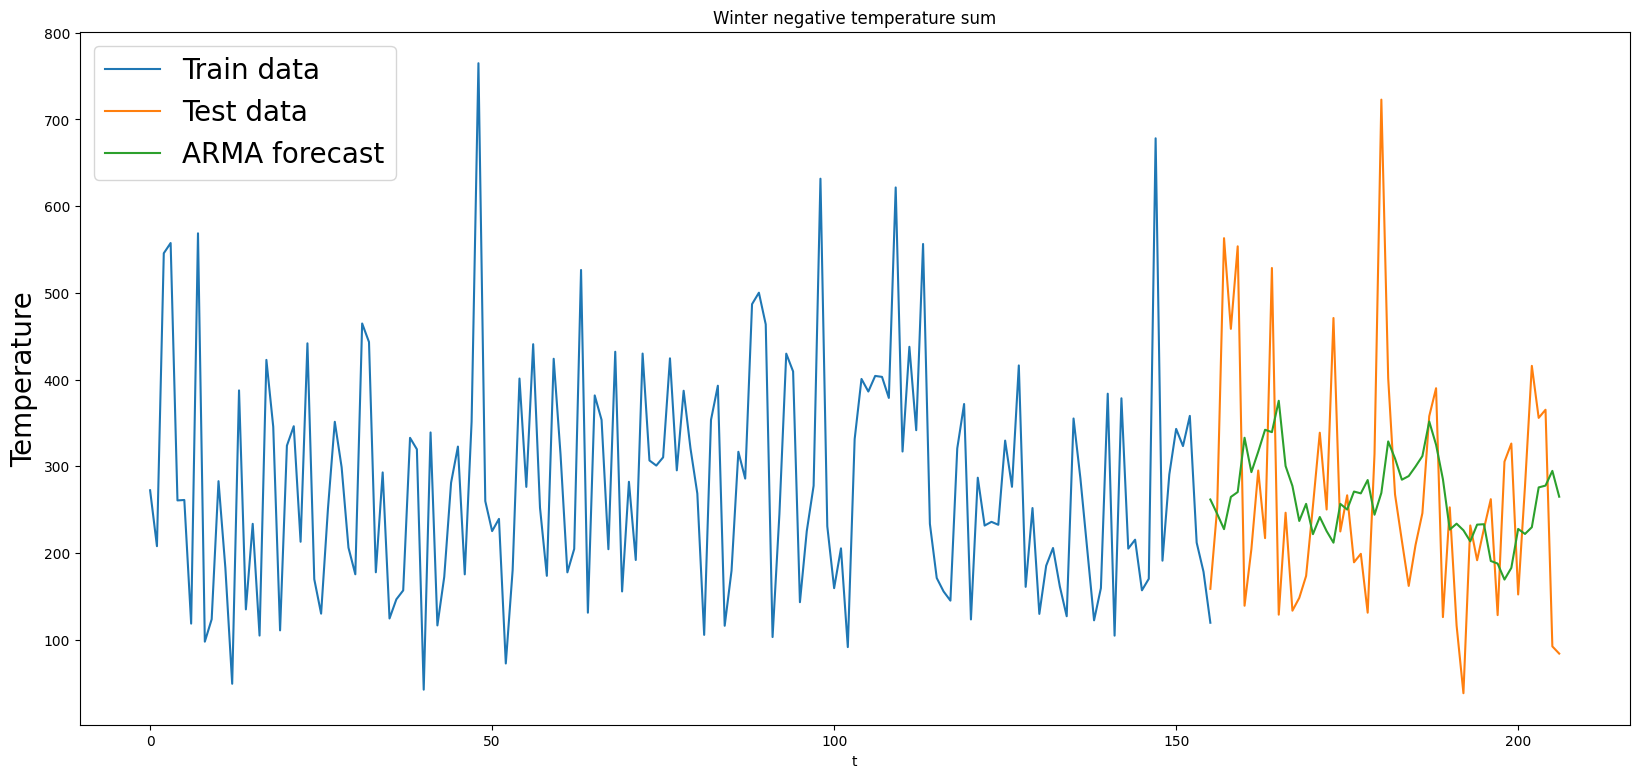

In [146]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_pred)

plt.plot([i for i in range(size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_pred, label='ARMA forecast')

plt.legend(fontsize="20")
plt.title('Winter negative temperature sum')
plt.ylabel('Temperature', fontsize="20")
plt.xlabel('t')

plt.show()

In [148]:
print("ARMA metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(train[size - len(arma_pred):size], arma_pred)))
print("MAPE:", mean_absolute_percentage_error(train[size - len(arma_pred):size], arma_pred))
print("MAE:", mean_absolute_error(train[size - len(arma_pred):size], arma_pred))
print("R2: ", r2_score(train[size - len(arma_pred):size], arma_pred))

ARMA metrics: 
RMSE: 134.4034029898451
MAPE: 0.44082389643136444
MAE: 105.59151251970192
R2:  -0.10892406362316942


In [135]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(10,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

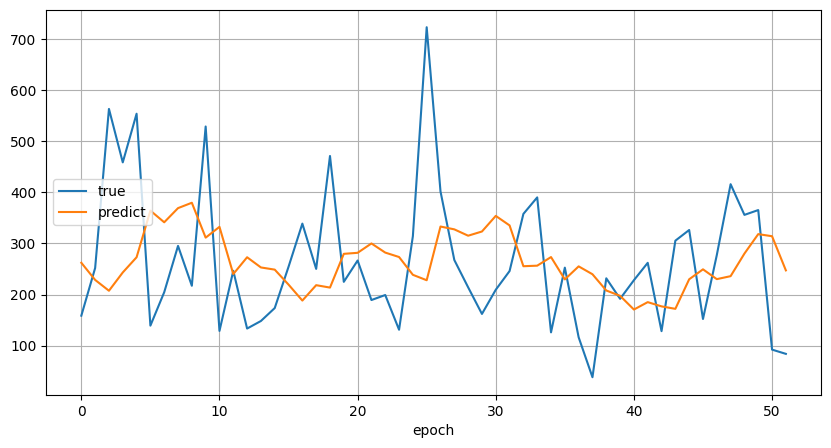

In [136]:
series = df.x

size = int(series.shape[0] * 0.75)
train, test = series[:size], series[size:len(series)]

history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5, 1, 0)).fit()
    output = model.forecast()
    yhat = output[0]

    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    
    live_plot(val)

In [174]:
arima_model = ARIMA(df.x, order=(7, 2, 0))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  208
Model:                 ARIMA(7, 2, 0)   Log Likelihood               -1344.642
Date:                Sun, 10 Mar 2024   AIC                           2705.283
Time:                        23:07:10   BIC                           2731.906
Sample:                             0   HQIC                          2716.050
                                - 208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4682      0.067    -21.942      0.000      -1.599      -1.337
ar.L2         -1.6254      0.126    -12.935      0.000      -1.872      -1.379
ar.L3         -1.5622      0.158     -9.901      0.0

In [175]:
output = arima_model_fit.forecast()

X = df.x.values

size = int(len(X) * 0.75) 
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
arima_pred = list()
for t in range(len(test)):
    arima_model = ARIMA(history, order=(7, 2, 0))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()

    arima_pred.append(output[0])
    history.append(test[t])

c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


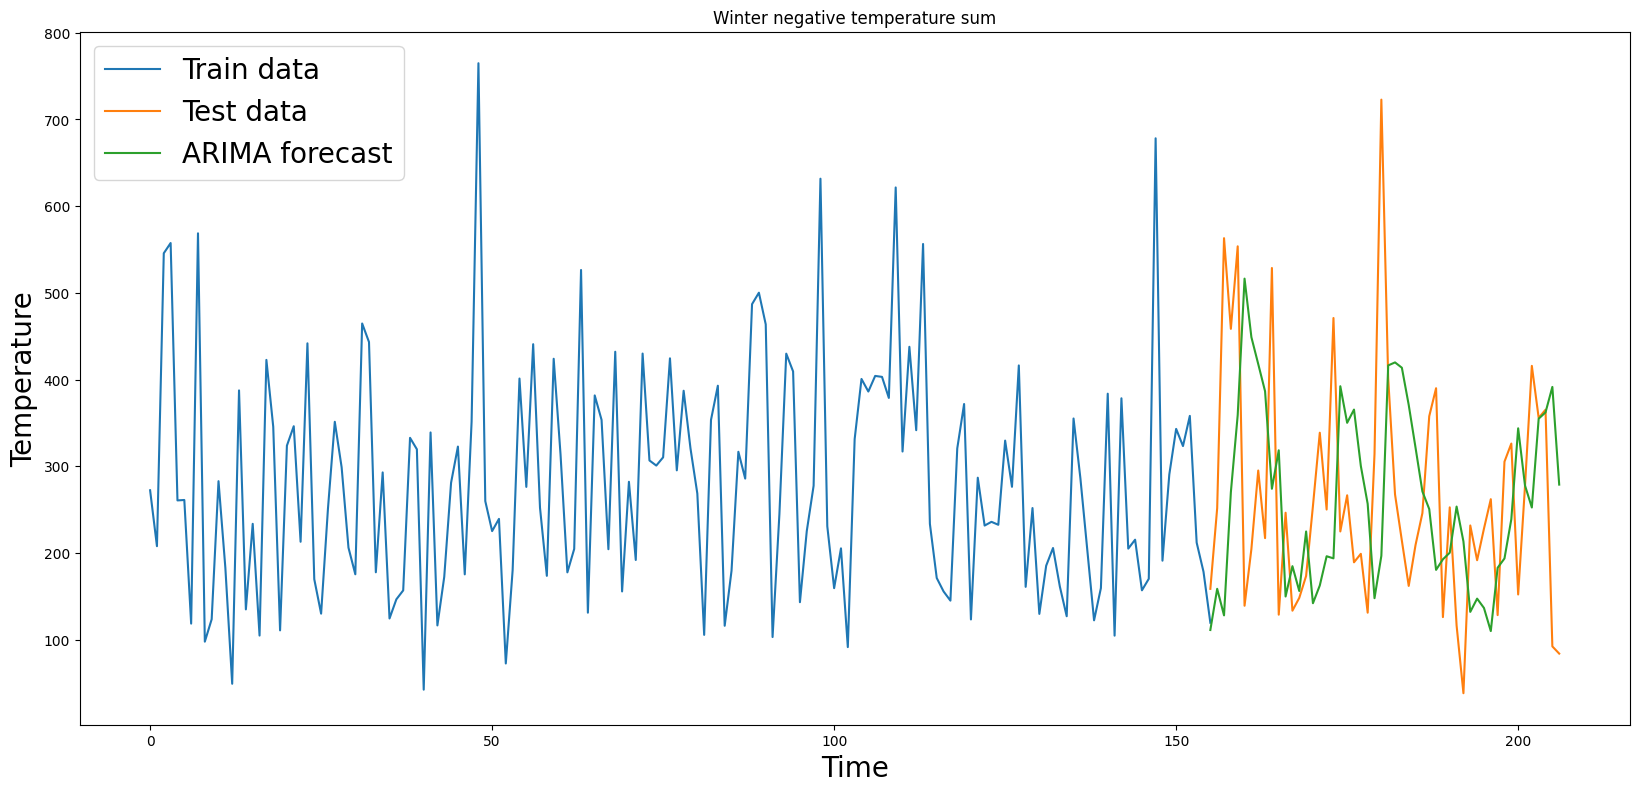

In [176]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_pred, label='ARIMA forecast')

plt.legend(fontsize="20")
plt.title('Winter negative temperature sum')
plt.ylabel('Temperature', fontsize="20")
plt.xlabel('Time', fontsize="20")

plt.show()

In [177]:
print("ARMA metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(train[size - len(arima_pred):size], arima_pred)))
print("MAPE:", mean_absolute_percentage_error(train[size - len(arima_pred):size], arima_pred))
print("MAE:", mean_absolute_error(train[size - len(arima_pred):size], arima_pred))
print("R2: ", r2_score(train[size - len(arima_pred):size], arima_pred))

ARMA metrics: 
RMSE: 152.7251874515289
MAPE: 0.4738367063786511
MAE: 116.30981502564772
R2:  -0.4318667746505229


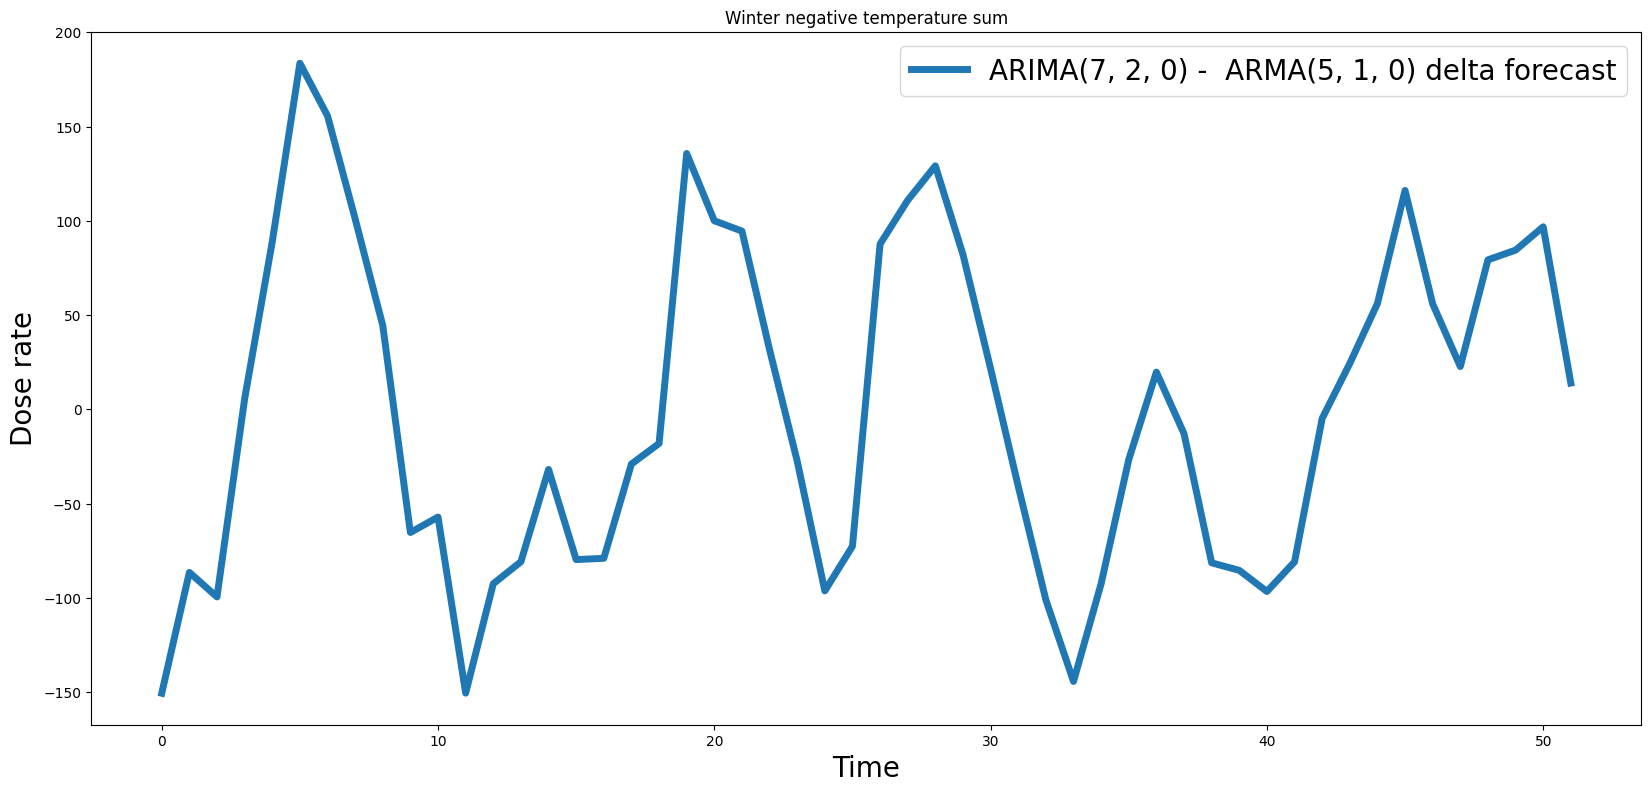

In [179]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_pred)):
    delta.append(arima_pred[i] - arma_pred[i])

plt.plot(delta, label='ARIMA(7, 2, 0) -  ARMA(5, 1, 0) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Winter negative temperature sum')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

***

### Заполнение пробелов

In [180]:
df2 = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv', index_col=0)
df2['t'] = pd.to_datetime({'year': df2.index.values + 1780,
                          'month': 1,
                          'day': 1})
df2.head()

,x,t
1,272.3,1782-01-01
2,207.8,1783-01-01
3,545.7,1784-01-01
4,557.5,1785-01-01
5,260.6,1786-01-01


C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\34353916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = np.nan


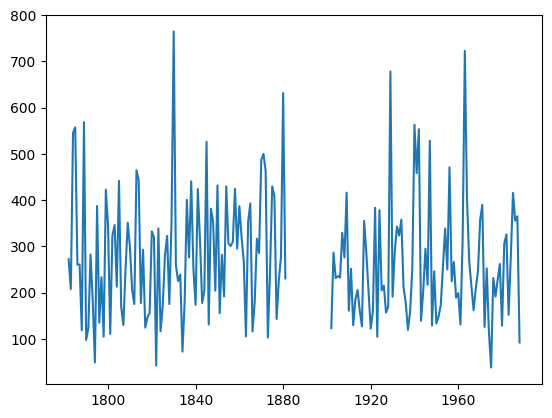

In [184]:
df2.x[100:120] = np.nan

plt.plot(df2.t, df2.x)

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\1076236399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = new_value


Text(0.5, 1.0, 'среднее из предыдущего и последующего')

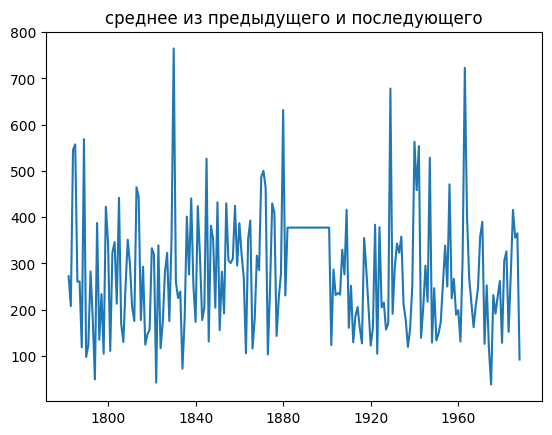

In [187]:
new_value = (df2.x[121] + df2.x[99]) / 2
df2.x[100:120] = new_value

plt.plot(df2.t, df2.x)
plt.title("среднее из предыдущего и последующего")

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\1004507220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = new_value


Text(0.5, 1.0, 'Последующее значение')

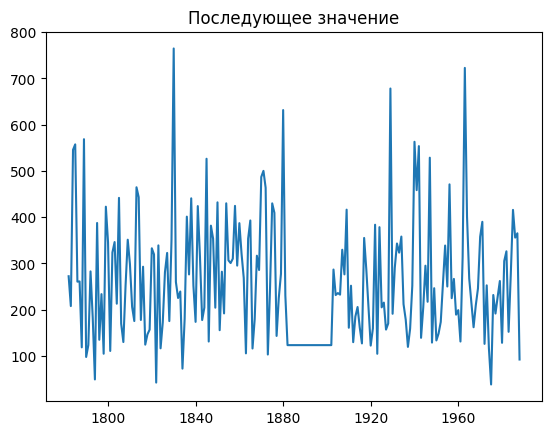

In [188]:
new_value = df2.x[121]

df2.x[100:120] = new_value

plt.plot(df2.t, df2.x)
plt.title("Последующее значение")

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\131550425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = new_value


Text(0.5, 1.0, 'Предыдущее значение')

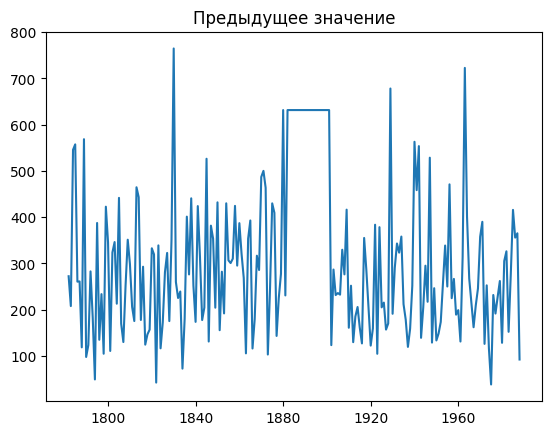

In [189]:
new_value = df2.x[99]

df2.x[100:120] = new_value

plt.plot(df2.t, df2.x)
plt.title("Предыдущее значение")

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\3588139964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = new_value


Text(0.5, 1.0, 'Общее срееднее')

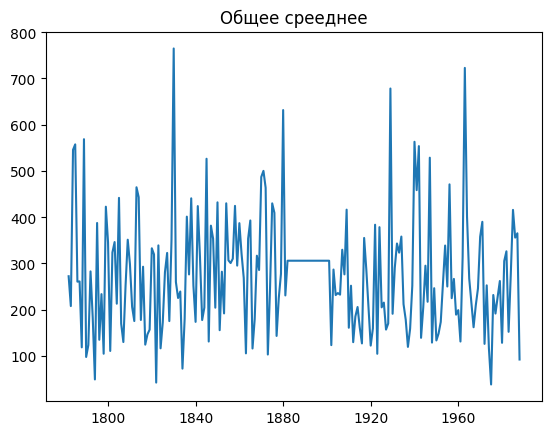

In [190]:
new_value = df2.x.mean()

df2.x[100:120] = new_value

plt.plot(df2.t, df2.x)
plt.title("Общее срееднее")

C:\Users\kufuk\AppData\Local\Temp\ipykernel_20108\565303720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.x[100:120] = np.nan


Text(0.5, 1.0, 'Zero')

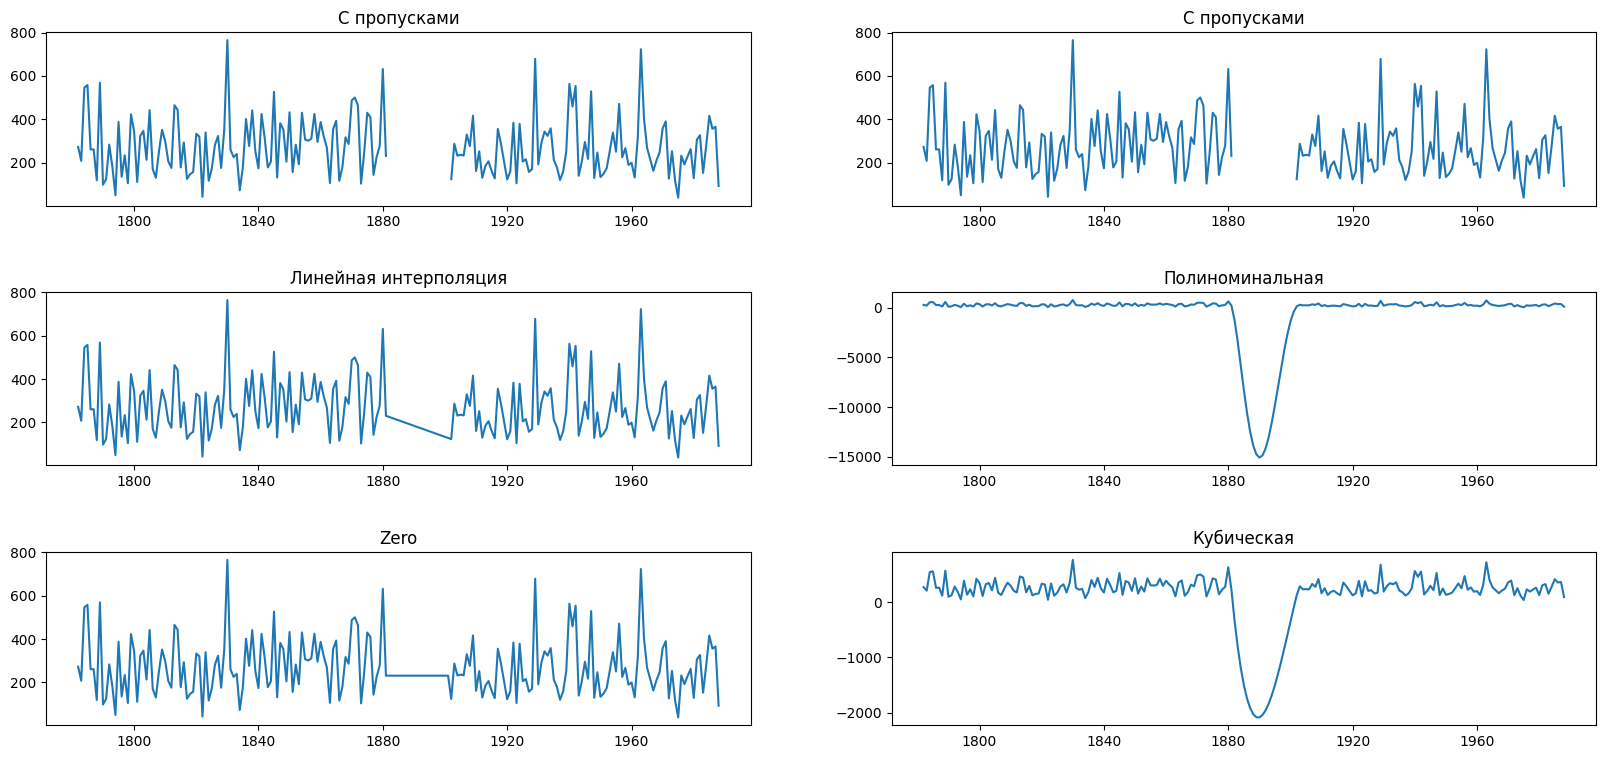

In [194]:
df2.x[100:120] = np.nan

lin_df2 = df2.x.interpolate(method="linear")
cub_df2 = df2.x.interpolate(method="cubic")
pol_df2 = df2.x.interpolate(method="polynomial", order=5)
zero_df2 = df2.x.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 

original_ax.plot(df2.t, df2.x)
original_ax.set_title("С пропусками")

plt.subplot2grid(layout, (0, 1))
plt.plot(df2.t, df2.x)
plt.title("С пропусками")

lin_ax.plot(df2.t, lin_df2)
lin_ax.set_title("Линейная интерполяция")
cub_ax.plot(df2.t, cub_df2)
cub_ax.set_title("Кубическая")
pol_ax.plot(df2.t, pol_df2)
pol_ax.set_title("Полиноминальная")
zero_ax.plot(df2.t, zero_df2)
zero_ax.set_title("Zero")

***

### Работа с выбросами

In [202]:
import seaborn as sns
from sklearn import preprocessing, svm

<Axes: >

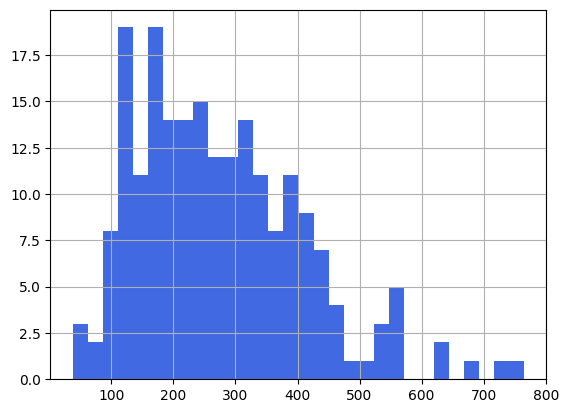

In [198]:
df.x.hist(bins=30, color="royalblue")

<Axes: ylabel='x'>

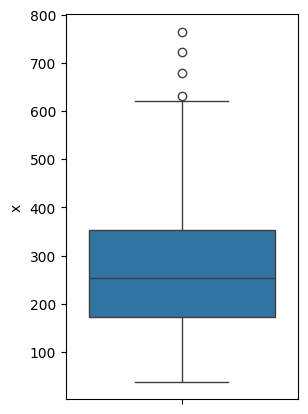

In [201]:
fig = plt.figure(figsize=(3, 5))
 
sns.boxplot(df.x)

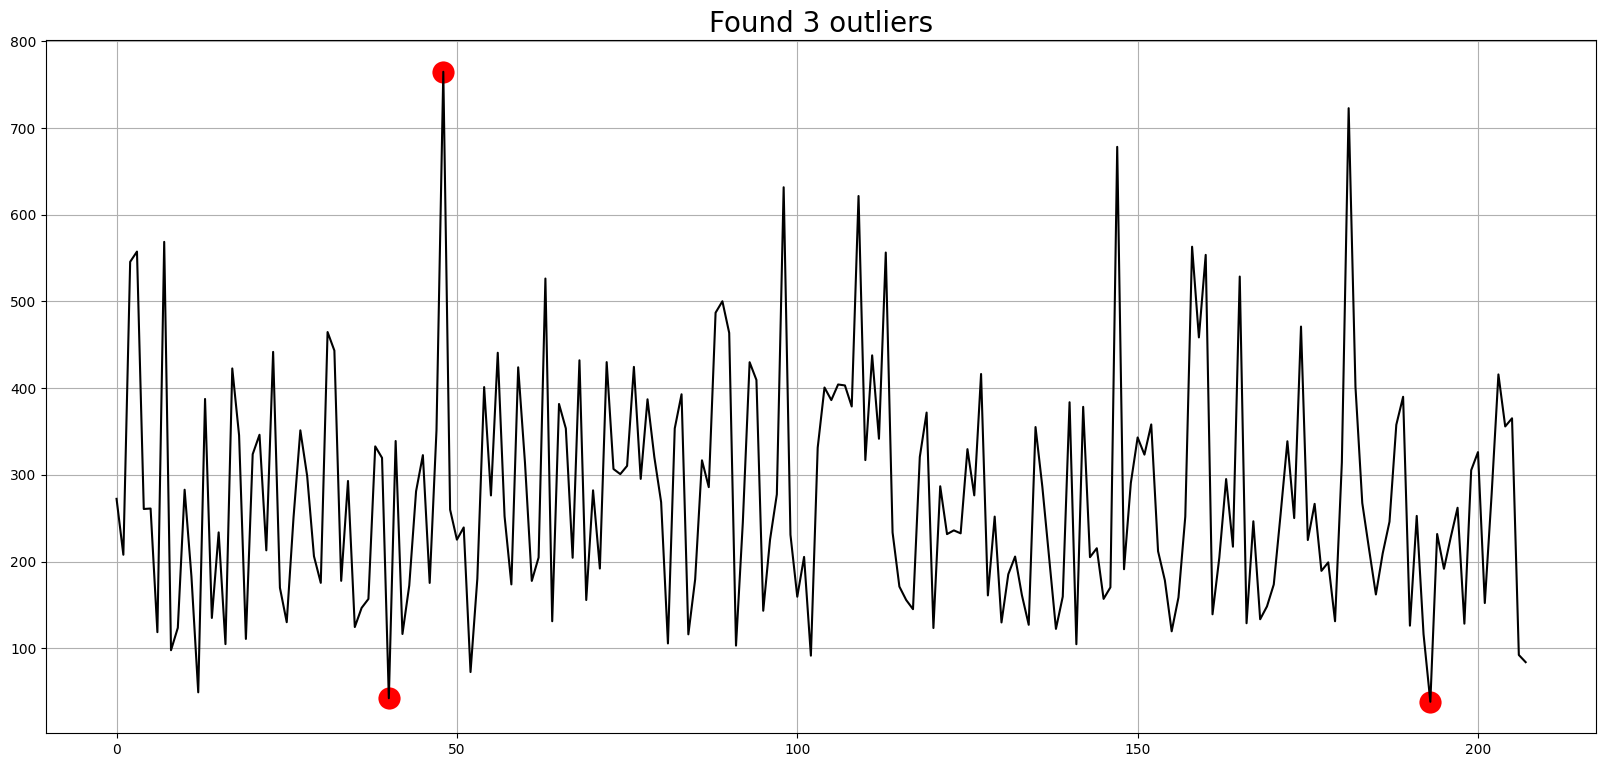

In [203]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = df.x

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)

dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x==-1 else 0)

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

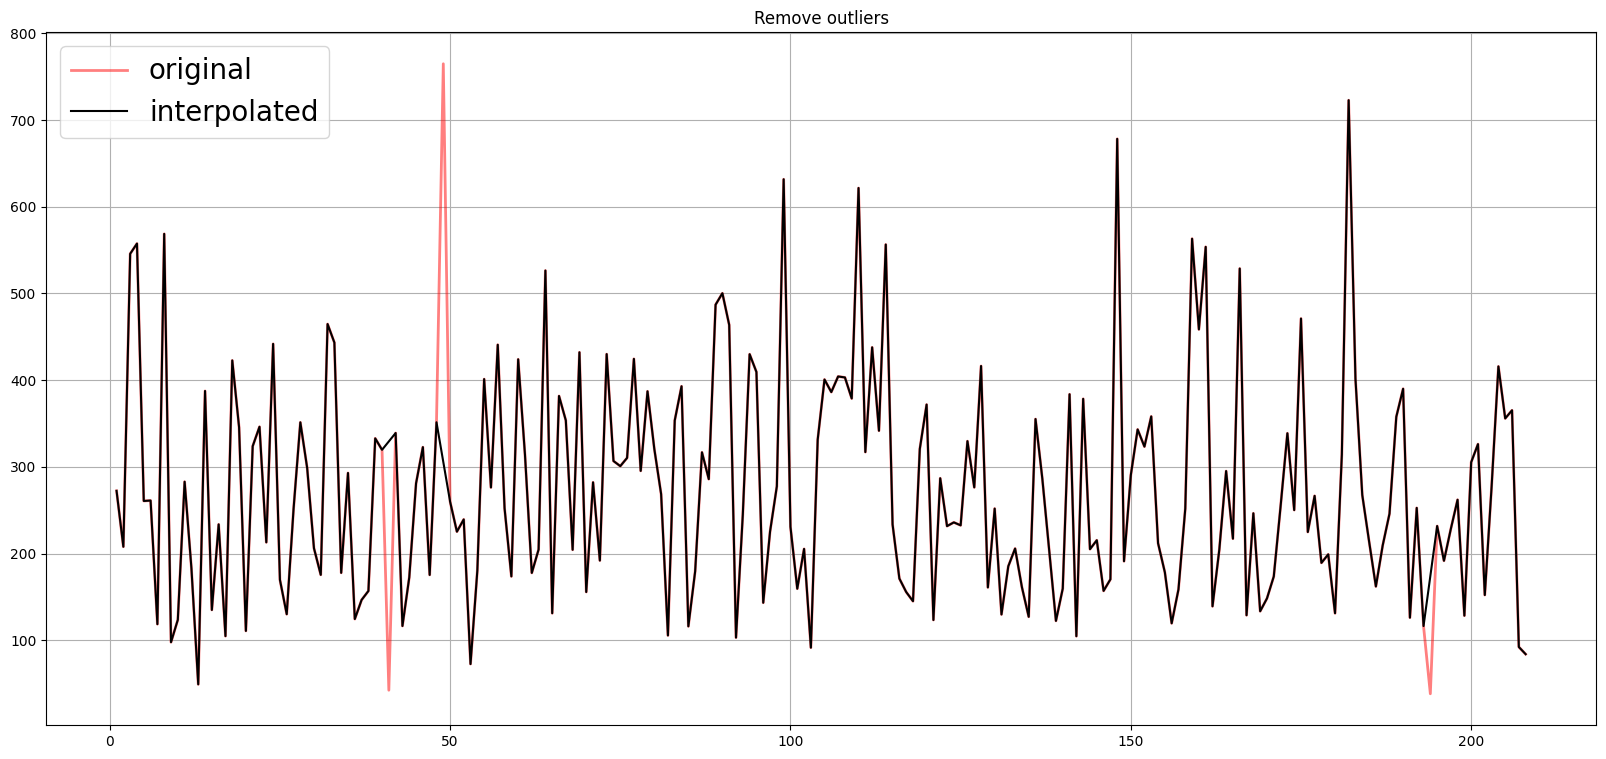

In [204]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()